# **[문제 1] 수업 자료 코드 실행 및 결과 제시**

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import os
import wandb
from pathlib import Path

In [2]:
BASE_PATH = Path.cwd().parent
print(BASE_PATH)

C:\Users\sjw99\git\link_dl


In [3]:
import sys
sys.path.append(BASE_PATH)

CURRENT_FILE_PATH = Path.cwd()
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"

if not CHECKPOINT_FILE_PATH.is_dir():
  CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

**1. _01_code/_18_lstm_and_its_application/g_crypto_currency_regression_train_lstm.py 실행 및 결과 제시**

In [4]:
from _01_code._18_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._17_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p__cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

* 데이터 전처리

p__cryptocurrency_dataset_dataloader / get_cryptocurrency_data 수정
```python
btc_krw_path = os.path.join(
    BASE_PATH, "_00_data", "_00_data", "k_cryptocurrency", "BTC_KRW.csv"
)

df = pd.read_csv(btc_krw_path)
df = df.iloc[3:].reset_index(drop=True)
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

row_size = len(df)
date_list = df['Date']

df = df.drop(columns=['Date'])

data_size = row_size - sequence_size
train_size = data_size - (validation_size + test_size)

In [5]:
def get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression, BASE_PATH=BASE_PATH
  )
  # data size = 4093 - 21 = 4072, data.shape : [4072, 11, 5]
  # X_train.shape: torch.Size([3892, 21, 5])
  # X_validation.shape: torch.Size([150, 21, 5])
  # X_test.shape: torch.Size([30, 21, 5])
  # y_train.shape: torch.Size([3891])
  # y_validation.shape: torch.Size([150])
  # y_test.shape: torch.Size([30]

  print("X_train.shape:", X_train.shape)
  print("X_validation.shape:", X_validation.shape)
  print("X_test.shape:", X_test.shape)
  print("y_train.shape:", y_train.shape)
  print("y_validation.shape:", y_validation.shape)
  print("y_test.shape:", y_test.shape)

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

In [6]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=128, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=128, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model

In [8]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

  # python _01_code/_11_lstm_and_its_application/f_crypto_currency_regression_train_lstm.py --wandb

In [9]:
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = True

args = Args()
main(args)

wandb: Currently logged in as: jwdam (jwdam-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'epochs': 100, 'batch_size': 32, 'validation_intervals': 5, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 0.001, 'weight_decay': 0.0001}
X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
Training on device cuda:0.
[Epoch   1] T_loss: 3.77084, V_loss: 12.48253, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.03465, V_loss: 1.38150, V_loss decreased (12.48253 --> 1.38150). Saving model... | T_time: 00:00:01, T_speed: 5.000
[Epoch  10] T_loss: 0.01550, V_loss: 0.79441, V_loss decreased (1.38150 --> 0.79441). Saving model... | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.00953, V_loss: 0.44076, V_loss decreased (0.79441 --> 0.44076). Saving model... | T_time: 00:00:04, T_speed: 3.750
[Epoch  20] T_loss: 0.00383, V_loss: 0.17145, V_loss decreased (

Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,100
Training loss,0.00086
Training speed (epochs/sec.),3.44828
Validation loss,0.08256


**2. _01_code/_18_lstm_and_its_application/h_crypto_currency_regression_test_lstm.py 실행 및 결과 제시**

In [6]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))

In [7]:
from matplotlib import pyplot as plt

def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True, BASE_PATH=BASE_PATH
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

In [15]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
        mode="disabled",
        project="lstm_regression_btc_krw",
        config={"batch_size": args.batch_size}
    )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

MODEL FILE: C:\Users\sjw99\git\link_dl\_04_your_code\checkpoints\lstm_regression_btc_krw_checkpoint_latest.pt


C:\Users\sjw99\AppData\Local\Temp\ipykernel_23332\760926358.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map_

X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[TEST DATA]
 0: 1,567.55 <--> 1,565.45 (Loss:          2.10)
 1: 1,510.55 <--> 1,504.83 (Loss:          5.72)
 2: 1,296.05 <--> 1,302.83 (Loss:          6.77)
 3: 1,329.91 <--> 1,341.92 (Loss:         12.01)
 4: 1,466.00 <--> 1,465.23 (Loss:          0.77)
 5: 1,330.50 <--> 1,333.17 (Loss:          2.67)
 6: 1,469.88 <--> 1,467.53 (Loss:          2.35)
 7: 1,226.35 <--> 1,250.72 (Loss:         24.36)
 8: 1,579.42 <--> 1,582.50 (Loss:          3.07)
 9: 1,521.33 <--> 1,524.84 (Loss:          3.51)
10: 1,331.59 <--> 1,334.95 (Loss:          3.37)
11: 1,526.06 <--> 1,523.51 (Loss:          2.54)
12: 1,338.95 <--> 1,334.35 (Loss:          4.60)
13: 1,486.88 <--> 1,489.17 (Loss:          2.29)
14: 1,571.25 <--> 1,572.57 (Loss:          1.32)
15: 1,537.79 <--> 1,544.47

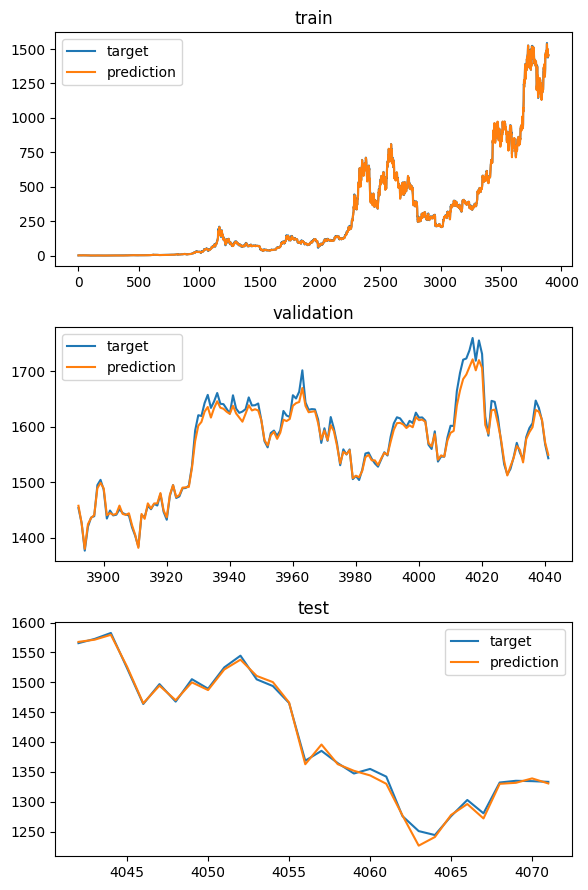

In [16]:
class Args:
    epochs = 100
    batch_size = 30 # TEST 데이터 전체
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False

args = Args()
main(args)

**3. _01_code/_18_lstm_and_its_application/i_crypto_currency_classification_train_lstm.py 실행 및 결과 제시**

In [6]:
from _01_code._09_fcn_best_practice.c_trainer import ClassificationTrainer

In [46]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

In [47]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


In [48]:
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = True

args = Args()
main(args)

{'epochs': 100, 'batch_size': 32, 'validation_intervals': 5, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 0.001, 'weight_decay': 0.0001}
X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
Training on device cuda:0.
[Epoch   1] T_loss: 0.69250, T_accuracy: 52.3895 | V_loss: 0.69292, V_accuracy: 50.6667 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69155, T_accuracy: 52.5437 | V_loss: 0.69400, V_accuracy: 49.3333 | Early stopping counter: 1 out of 5 | T_time: 00:00:03, T_speed: 1.667
[Epoch  10] T_loss: 0.69133, T_accuracy: 52.7235 | V_loss: 0.69364, V_accuracy: 49.3333 | Early stopping counter: 2 out of 5 | T_time: 00:00:07, T_speed: 1.429
[Epoch  15] T_loss: 0.69118, T_accuracy: 52.9034 | V_loss: 0.69316, V_accuracy: 49.3333 | Early stopping counter:

Epoch,▁▂▄▅▇█
Training accuracy (%),▁▂▄▆█▆
Training loss,█▃▂▁▂▁
Training speed (epochs/sec.),▁█▇▇▇▇
Validation accuracy (%),█▁▁▁▁▁
Validation loss,▁▅▄▂█▁
Epoch,25
Training accuracy (%),52.8777
Training loss,0.69114
Training speed (epochs/sec.),1.47059
Validation accuracy (%),49.33333


**4. _01_code/_18_lstm_and_its_application/j_crypto_currency_classification_test_lstm.py 실행 및 결과 제시**

In [7]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [11]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

In [12]:
class Args:
    epochs = 100
    batch_size = 30 # TEST 데이터 전체
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False

args = Args()
main(args)

MODEL FILE: C:\Users\sjw99\git\link_dl\_04_your_code\checkpoints\lstm_classification_btc_krw_checkpoint_latest.pt


C:\Users\sjw99\AppData\Local\Temp\ipykernel_27760\1053702361.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load(latest_file_path, map

X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[TEST DATA]
TEST RESULTS: 66.667%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   0.00
 5:   0.00 <-->   0.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   0.00
11:   1.00 <-->   1.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   1.00 <-->   0.00
16:   0.00 <-->   1.00
17:   1.00 <-->   1.00
18:   0.00 <-->   0.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   1.00
22:   0.00 <-->   0.00
23:   1.00 <-->   1.00
24:   0.00 <-->   0.00
25:   0.00 <-->   0.00
26:   1.00 <-->   0.00
27:   1.00 <-->   0.00
28:   1.00 <-->   0.00
29:   0.00 <-->   1.00


# **[문제 2] 적절한 새로운 모델 구성 및 하이퍼파라미터 찾기**

**1. 공통 모델 생성 함수**

In [8]:
def get_model(n_input, n_output, hidden_size, lstm_layers, fc_layers, dropout):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=lstm_layers,
                dropout=dropout if lstm_layers > 1 else 0.0,
                batch_first=True
            )

            layers = []
            in_dim = hidden_size
            for _ in range(fc_layers - 1):
                layers.append(nn.Linear(in_dim, in_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(in_dim, n_output))

            self.fcn = nn.Sequential(*layers)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]
            return self.fcn(x)

    return MyModel()

**2. Regression 실험 세팅**

In [17]:
REGRESSION_EXPERIMENTS = [
    dict(
        name="R1_L2_FC1_dp0",
        lstm_layers=2, fc_layers=1, dropout=0.0, weight_decay=1e-4,
        # 기준선: 시계열 길이 21, 과도한 규제 없이 기본 성능 확인
    ),
    dict(
        name="R2_L3_FC1_dp01",
        lstm_layers=3, fc_layers=1, dropout=0.1, weight_decay=1e-4,
        # 중기 패턴 포착 기대 → LSTM depth 증가
    ),
    dict(
        name="R3_L2_FC2_dp01",
        lstm_layers=2, fc_layers=2, dropout=0.1, weight_decay=1e-4,
        # LSTM feature + FC 비선형 회귀 강화
    ),
    dict(
        name="R4_L3_FC2_dp01",
        lstm_layers=3, fc_layers=2, dropout=0.1, weight_decay=1e-4,
        # 표현력 극대화, 규제는 최소
    ),
    dict(
        name="R5_L2_FC2_dp03",
        lstm_layers=2, fc_layers=2, dropout=0.3, weight_decay=1e-4,
        # train 대비 val 작음 → dropout으로 과적합 억제
    ),
    dict(
        name="R6_L2_FC1_wd1e3",
        lstm_layers=2, fc_layers=1, dropout=0.0, weight_decay=1e-3,
        # L2 규제로 파라미터 폭주 억제
    ),
]

**3. Regression 실험 실행**

In [18]:
def run_regression_experiments(args, EXPERIMENTS):
    for exp in EXPERIMENTS:
        run_time_str = f"{exp['name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

        wandb.init(
            project="lstm_regression_btc_krw_experiments",
            name=exp["name"],
            config={**exp, **vars(args)},
        )

        train_loader, val_loader, _ = get_btc_krw_data(is_regression=True)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = get_model(
            n_input=5,
            n_output=1,
            hidden_size=128,
            lstm_layers=exp["lstm_layers"],
            fc_layers=exp["fc_layers"],
            dropout=exp["dropout"],
        ).to(device)

        optimizer = optim.Adam(
            model.parameters(),
            lr=args.learning_rate,
            weight_decay=exp["weight_decay"],
        )

        trainer = RegressionTrainer(
            "lstm_regression_btc_krw",
            model,
            optimizer,
            train_loader,
            val_loader,
            None,
            run_time_str,
            wandb,
            device,
            CHECKPOINT_FILE_PATH,
        )

        trainer.train_loop()
        wandb.finish()

In [19]:
class Args:
    def __init__(self):
        self.epochs = 100
        self.batch_size = 32
        self.validation_intervals = 5
        self.learning_rate = 0.001
        self.early_stop_patience = 5
        self.early_stop_delta = 0.001
        self.weight_decay = 1e-4
        self.wandb = True

args = Args()


In [20]:
run_regression_experiments(args, REGRESSION_EXPERIMENTS)

X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 3.32822, V_loss: 10.87452, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.02564, V_loss: 1.69684, V_loss decreased (10.87452 --> 1.69684). Saving model... | T_time: 00:00:01, T_speed: 5.000
[Epoch  10] T_loss: 0.01248, V_loss: 0.67870, V_loss decreased (1.69684 --> 0.67870). Saving model... | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.00702, V_loss: 0.19901, V_loss decreased (0.67870 --> 0.19901). Saving model... | T_time: 00:00:04, T_speed: 3.750
[Epoch  20] T_loss: 0.00371, V_loss: 0.15891, V_loss decreased (0.19901 --> 0.15891). Saving model... | T_time: 00:00:06, T_speed: 3.333
[Epoch  25] T_loss: 0.00593, V_loss: 0.07031, V_loss decreased (0.15891 --> 0.07031). Saving model... | T_time: 00:0

Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,100
Training loss,0.00411
Training speed (epochs/sec.),3.44828
Validation loss,0.11337


wandb: Currently logged in as: jwdam (jwdam-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 3.15705, V_loss: 10.56323, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.04835, V_loss: 1.48638, V_loss decreased (10.56323 --> 1.48638). Saving model... | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.03174, V_loss: 1.01575, V_loss decreased (1.48638 --> 1.01575). Saving model... | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.03095, V_loss: 0.61316, V_loss decreased (1.01575 --> 0.61316). Saving model... | T_time: 00:00:05, T_speed: 3.000
[Epoch  20] T_loss: 0.02439, V_loss: 1.26955, Early stopping counter: 1 out of 5 | T_time: 00:00:07, T_speed: 2.857
[Epoch  25] T_loss: 0.01887, V_loss: 1.12484, Early stopping counter: 2 out of 5 | T_time: 00:00:09, T_speed: 2.778
[Epoch  30] T_loss: 0

Epoch,▁▁▂▃▃▄▄▅▅▆▆▇▇█
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▆█▇▇▇▇▇▇▇▇▇▇▇
Validation loss,█▂▁▁▂▂▁▁▁▁▁▁▁▁
Epoch,65
Training loss,0.01204
Training speed (epochs/sec.),2.95455
Validation loss,0.46197


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 3.62645, V_loss: 1.66886, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.09437, V_loss: 0.38075, V_loss decreased (1.66886 --> 0.38075). Saving model... | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.07805, V_loss: 0.18136, V_loss decreased (0.38075 --> 0.18136). Saving model... | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.07354, V_loss: 1.05556, Early stopping counter: 1 out of 5 | T_time: 00:00:05, T_speed: 3.000
[Epoch  20] T_loss: 0.07810, V_loss: 0.96049, Early stopping counter: 2 out of 5 | T_time: 00:00:07, T_speed: 2.857
[Epoch  25] T_loss: 0.07153, V_loss: 0.45042, Early stopping counter: 3 out of 5 | T_time: 00:00:08, T_speed: 3.125
[Epoch  30] T_loss: 0.07280, V_loss: 0.09620

Epoch,▁▂▂▃▃▄▅▅▆▇▇█
Training loss,█▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▆█▇▇█▇▇▇▇█▇
Validation loss,█▂▁▅▅▃▁▂▂▄▃▇
Epoch,55
Training loss,0.05822
Training speed (epochs/sec.),3.05556
Validation loss,1.4711


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 3.78811, V_loss: 3.70060, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.08789, V_loss: 1.66784, V_loss decreased (3.70060 --> 1.66784). Saving model... | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.10893, V_loss: 1.80446, Early stopping counter: 1 out of 5 | T_time: 00:00:04, T_speed: 2.500
[Epoch  15] T_loss: 0.08730, V_loss: 1.17442, V_loss decreased (1.66784 --> 1.17442). Saving model... | T_time: 00:00:06, T_speed: 2.500
[Epoch  20] T_loss: 0.07193, V_loss: 1.56714, Early stopping counter: 1 out of 5 | T_time: 00:00:08, T_speed: 2.500
[Epoch  25] T_loss: 0.09384, V_loss: 0.55113, V_loss decreased (1.17442 --> 0.55113). Saving model... | T_time: 00:00:10, T_speed: 2.500
[Epoch  30] T_loss: 0.0

Epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▇▇▇▇▇████████████
Validation loss,█▄▄▃▄▂▂▁▂▁▃▃▁▃▂▂▃▂
Epoch,85
Training loss,0.06166
Training speed (epochs/sec.),2.74194
Validation loss,0.55615


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 3.64235, V_loss: 1.95460, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.24177, V_loss: 3.01413, Early stopping counter: 1 out of 5 | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.24855, V_loss: 1.86410, V_loss decreased (1.95460 --> 1.86410). Saving model... | T_time: 00:00:04, T_speed: 2.500
[Epoch  15] T_loss: 0.24136, V_loss: 1.01241, V_loss decreased (1.86410 --> 1.01241). Saving model... | T_time: 00:00:07, T_speed: 2.143
[Epoch  20] T_loss: 0.20998, V_loss: 0.99199, V_loss decreased (1.01241 --> 0.99199). Saving model... | T_time: 00:00:08, T_speed: 2.500
[Epoch  25] T_loss: 0.19002, V_loss: 2.57637, Early stopping counter: 1 out of 5 | T_time: 00:00:10, T_speed: 2.500
[Epoch  30] T_loss: 0.1

Epoch,▁▁▂▃▃▄▄▅▆▆▇▇█
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁██▇█████████
Validation loss,▅█▅▃▃▇▄▁▄▄▃▁▃
Epoch,60
Training loss,0.16098
Training speed (epochs/sec.),2.6087
Validation loss,0.92309


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 3.49762, V_loss: 13.17579, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.03345, V_loss: 1.40591, V_loss decreased (13.17579 --> 1.40591). Saving model... | T_time: 00:00:01, T_speed: 5.000
[Epoch  10] T_loss: 0.02576, V_loss: 1.12370, V_loss decreased (1.40591 --> 1.12370). Saving model... | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.03057, V_loss: 0.30308, V_loss decreased (1.12370 --> 0.30308). Saving model... | T_time: 00:00:05, T_speed: 3.000
[Epoch  20] T_loss: 0.01521, V_loss: 0.29003, V_loss decreased (0.30308 --> 0.29003). Saving model... | T_time: 00:00:07, T_speed: 2.857
[Epoch  25] T_loss: 0.01060, V_loss: 0.29080, Early stopping counter: 1 out of 5 | T_time: 00:00:09, T_speed: 2.778


Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇██
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
Validation loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,100
Training loss,0.0049
Training speed (epochs/sec.),3.22581
Validation loss,0.01823


**4. Regression 실험 결과 분석**

In [56]:
import pandas as pd

In [68]:
def summarize_runs(project_path, metric):
    api = wandb.Api()
    runs = api.runs(project_path)

    rows = []

    for run in runs:
        hist = pd.DataFrame(run.scan_history(keys=[metric]))
        if hist.empty:
            continue

        rows.append({
        "run_name": run.name,
        "lstm_layers": run.config.get("lstm_layers"),
        "fc_layers": run.config.get("fc_layers"),
        "dropout": run.config.get("dropout"),
        "weight_decay": run.config.get("weight_decay"),
        "last10_mean": hist[metric].tail(10).mean(), # 마지막 epoch 10개 값의 평균
        "min_value": hist[metric].min(),
        })

    return pd.DataFrame(rows)


In [69]:
df_reg = summarize_runs(
    "jwdam-korea-university-of-technology-and-education/lstm_regression_btc_krw_experiments",
    metric="Validation loss",
)
df_reg.sort_values("min_value")

,run_name,lstm_layers,fc_layers,dropout,weight_decay,last10_mean,min_value
5,R6_L2_FC1_wd1e3,2,1,0.0,0.0001,0.139897,0.018177
0,R1_L2_FC1_dp0,2,1,0.0,0.0001,0.069139,0.035032
2,R3_L2_FC2_dp01,2,2,0.1,0.0001,0.322078,0.068162
4,R5_L2_FC2_dp03,2,2,0.3,0.0001,1.113072,0.224439
1,R2_L3_FC1_dp01,3,1,0.1,0.0001,0.559332,0.268173
3,R4_L3_FC2_dp01,3,2,0.1,0.0001,0.855972,0.403667


- **Regression 실험 결과 및 최종 모델 판단**
1. WandB에서 확인한 Validation loss 수치와 학습 곡선을 종합적으로 비교한 결과, **LSTM 2개 layer + LSTM 출력 이후 단일 FC layer를 사용하고 dropout을 적용하지 않은 모델**이 가장 우수한 성능을 보였다.
2. 수치적으로는 해당 모델이 Validation loss의 **마지막 10 epoch 평균값이 가장 낮아** 학습 후반부 성능이 가장 안정적이었으며, 그래프 상에서도 학습 초반 이후 Validation loss가 빠르게 감소한 뒤 **큰 진동 없이 안정적으로 수렴**하는 양상을 보였다.
3. 반면, LSTM layer 수를 늘리거나 FC layer 및 dropout을 추가한 모델들은 일시적으로 더 낮은 loss에 도달하는 경우는 있었으나, 학습 후반부에서 변동 폭이 커지거나 평균 성능이 악화되는 경향을 보였다.
4. 따라서 Regression 문제에서는 과도한 모델 복잡도보다 **비교적 단순한 LSTM 구조가 일반화 성능 측면에서 가장 적절한 모델 구성**으로 판단된다.


**6. Regression 출력 그래프**

In [31]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"

  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  # 최고 성능 모델(R1_L2_FC1_dp0)
  test_model = get_model(
    n_input=5,
    n_output=1,
    hidden_size=128,
    lstm_layers=2,
    fc_layers=1,
    dropout=0.0,
  )

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH,
    f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE:", latest_file_path)

  test_model.load_state_dict(
    torch.load(latest_file_path, map_location=torch.device('cpu'))
  )

  test(test_model)
  predict_all(test_model)


MODEL FILE: C:\Users\sjw99\git\link_dl\_04_your_code\checkpoints\lstm_regression_btc_krw_checkpoint_latest.pt


C:\Users\sjw99\AppData\Local\Temp\ipykernel_28296\3087646431.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(latest_file_path, map_location=torch.device('cpu

X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[TEST DATA]
 0: 1,492.37 <--> 1,467.53 (Loss:         24.84)
 1: 1,384.28 <--> 1,364.62 (Loss:         19.66)
 2: 1,230.91 <--> 1,250.72 (Loss:         19.81)
 3: 1,512.92 <--> 1,493.60 (Loss:         19.31)
 4: 1,345.58 <--> 1,341.92 (Loss:          3.66)
 5: 1,591.27 <--> 1,572.57 (Loss:         18.70)
 6: 1,346.32 <--> 1,333.17 (Loss:         13.15)
 7: 1,373.68 <--> 1,368.62 (Loss:          5.06)
 8: 1,294.93 <--> 1,275.71 (Loss:         19.22)
 9: 1,536.39 <--> 1,524.84 (Loss:         11.55)
10: 1,582.34 <--> 1,565.45 (Loss:         16.89)
11: 1,506.26 <--> 1,496.84 (Loss:          9.43)
12: 1,509.79 <--> 1,505.08 (Loss:          4.71)
13: 1,524.57 <--> 1,504.83 (Loss:         19.74)
14: 1,352.22 <--> 1,334.35 (Loss:         17.87)
15: 1,288.60 <--> 1,280.50

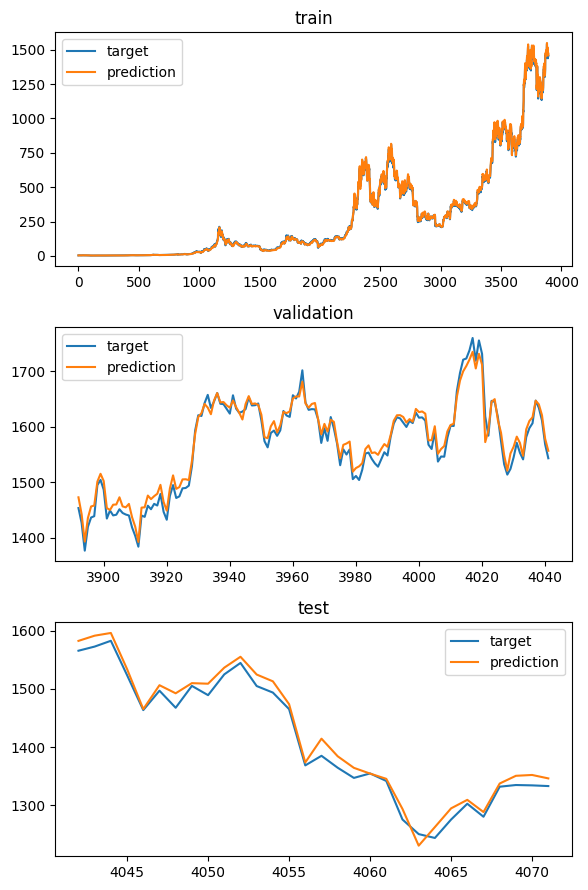

In [32]:
class Args:
    epochs = 100
    batch_size = 30   # TEST 전체
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False


args = Args()
main(args)

**7. Classification 실험 세팅**
- Classification은 출력이 불연속적이어서 입력의 미세한 차이를 구분해야 하므로,
Regression보다 모델 표현력이 필요하며 과적합을 막기 위한 규제도 함께 필요

In [70]:
CLASSIFICATION_EXPERIMENTS = [
    dict(
        name="C1_L2_FC1_dp01",
        lstm_layers=2, fc_layers=1, dropout=0.1, weight_decay=1e-4,
        # 기준선: 방향성 분류 기본 성능
    ),
    dict(
        name="C2_L3_FC1_dp02",
        lstm_layers=3, fc_layers=1, dropout=0.2, weight_decay=1e-4,
        # 시계열 방향성 강화 → LSTM depth 증가
    ),
    dict(
        name="C3_L2_FC2_dp03",
        lstm_layers=2, fc_layers=2, dropout=0.3, weight_decay=1e-4,
        # 결정 경계 복잡 → FC depth + dropout
    ),
    dict(
        name="C4_L3_FC2_dp03",
        lstm_layers=3, fc_layers=2, dropout=0.3, weight_decay=1e-4,
        # 표현력 + 규제 균형
    ),
    dict(
        name="C5_L3_FC2_dp04_wd1e3",
        lstm_layers=3, fc_layers=2, dropout=0.4, weight_decay=1e-3,
        # noisy한 BTC 데이터 → 강한 규제 실험
    ),
]


**6. Classification 실험 실행**

In [71]:
def run_classification_experiments(args):
    for exp in CLASSIFICATION_EXPERIMENTS:
        run_time_str = f"{exp['name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

        wandb.init(
            project="lstm_classification_btc_krw_experiments",
            name=exp["name"],
            config={**exp, **vars(args)},
        )

        train_loader, val_loader, _ = get_btc_krw_data(is_regression=False)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        model = get_model(
            n_input=5,
            n_output=2,
            hidden_size=128,
            lstm_layers=exp["lstm_layers"],
            fc_layers=exp["fc_layers"],
            dropout=exp["dropout"],
        ).to(device)

        optimizer = optim.Adam(
            model.parameters(),
            lr=args.learning_rate,
            weight_decay=exp["weight_decay"],
        )

        trainer = ClassificationTrainer(
            "lstm_classification_btc_krw",
            model,
            optimizer,
            train_loader,
            val_loader,
            None,
            run_time_str,
            wandb,
            device,
            CHECKPOINT_FILE_PATH,
        )

        trainer.train_loop()
        wandb.finish()


In [72]:
run_classification_experiments(args)

X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 0.69322, T_accuracy: 51.5159 | V_loss: 0.69265, V_accuracy: 52.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69158, T_accuracy: 52.7235 | V_loss: 0.69219, V_accuracy: 50.6667 | Early stopping counter: 1 out of 5 | T_time: 00:00:01, T_speed: 5.000
[Epoch  10] T_loss: 0.69132, T_accuracy: 52.7235 | V_loss: 0.69285, V_accuracy: 53.3333 | Early stopping counter: 2 out of 5 | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.69143, T_accuracy: 53.1089 | V_loss: 0.69326, V_accuracy: 49.3333 | Early stopping counter: 3 out of 5 | T_time: 00:00:05, T_speed: 3.000
[Epoch  20] T_loss: 0.69108, T_accuracy: 52.8777 | V_loss: 0.69269, V_accuracy: 52.6667 | Early stopping counter: 4 out of 5 | T_time: 00:00:0

Epoch,▁▂▄▅▇█
Training accuracy (%),▁▆▆█▇█
Training loss,█▃▂▂▁▁
Training speed (epochs/sec.),▁█▆▅▆▅
Validation accuracy (%),▅▃▆▁▅█
Validation loss,▄▁▅█▄▅
Epoch,25
Training accuracy (%),53.10894
Training loss,0.69103
Training speed (epochs/sec.),3.125
Validation accuracy (%),54.66667


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 0.69159, T_accuracy: 53.3916 | V_loss: 0.69324, V_accuracy: 49.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69170, T_accuracy: 52.8777 | V_loss: 0.69360, V_accuracy: 49.3333 | Early stopping counter: 1 out of 5 | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.69144, T_accuracy: 52.8263 | V_loss: 0.69294, V_accuracy: 50.6667 | Early stopping counter: 2 out of 5 | T_time: 00:00:04, T_speed: 2.500
[Epoch  15] T_loss: 0.69120, T_accuracy: 52.8263 | V_loss: 0.69441, V_accuracy: 49.3333 | Early stopping counter: 3 out of 5 | T_time: 00:00:05, T_speed: 3.000
[Epoch  20] T_loss: 0.69159, T_accuracy: 52.6978 | V_loss: 0.69325, V_accuracy: 49.3333 | Early stopping counter: 4 out of 5 | T_time: 00:00:0

Epoch,▁▂▄▅▇█
Training accuracy (%),█▄▄▄▃▁
Training loss,▆█▄▁▆▃
Training speed (epochs/sec.),▁▇▇██▇
Validation accuracy (%),▁▁█▁▁▁
Validation loss,▂▄▁█▂▇
Epoch,25
Training accuracy (%),52.4409
Training loss,0.69132
Training speed (epochs/sec.),2.77778
Validation accuracy (%),49.33333


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 0.69302, T_accuracy: 52.3895 | V_loss: 0.69374, V_accuracy: 49.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69147, T_accuracy: 52.8263 | V_loss: 0.69403, V_accuracy: 49.3333 | Early stopping counter: 1 out of 5 | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.69111, T_accuracy: 52.8263 | V_loss: 0.69316, V_accuracy: 49.3333 | Early stopping counter: 2 out of 5 | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.69140, T_accuracy: 52.8777 | V_loss: 0.69335, V_accuracy: 49.3333 | Early stopping counter: 3 out of 5 | T_time: 00:00:05, T_speed: 3.000
[Epoch  20] T_loss: 0.69133, T_accuracy: 52.8777 | V_loss: 0.69433, V_accuracy: 49.3333 | Early stopping counter: 4 out of 5 | T_time: 00:00:0

Epoch,▁▂▄▅▇█
Training accuracy (%),▁▇▇███
Training loss,█▂▁▂▂▂
Training speed (epochs/sec.),▁▆█▇▇▇
Validation accuracy (%),▁▁▁▁▁▁
Validation loss,▄▆▁▂█▅
Epoch,25
Training accuracy (%),52.8777
Training loss,0.69128
Training speed (epochs/sec.),2.77778
Validation accuracy (%),49.33333


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 0.69197, T_accuracy: 52.6208 | V_loss: 0.69705, V_accuracy: 49.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69164, T_accuracy: 52.9291 | V_loss: 0.69399, V_accuracy: 49.3333 | V_loss decreased (0.69705 --> 0.69399). Saving model... | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.69167, T_accuracy: 52.9034 | V_loss: 0.69316, V_accuracy: 49.3333 | Early stopping counter: 1 out of 5 | T_time: 00:00:05, T_speed: 2.000
[Epoch  15] T_loss: 0.69161, T_accuracy: 52.6721 | V_loss: 0.69510, V_accuracy: 49.3333 | Early stopping counter: 2 out of 5 | T_time: 00:00:07, T_speed: 2.143
[Epoch  20] T_loss: 0.69127, T_accuracy: 52.8006 | V_loss: 0.69370, V_accuracy: 49.3333 | Early stopping counter: 3 out o

Epoch,▁▂▃▄▆▇█
Training accuracy (%),▁▇▇▂▅▃█
Training loss,█▆▆▆▄▃▁
Training speed (epochs/sec.),▁█▇▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁█
Validation loss,█▂▁▄▂▁▄
Epoch,30
Training accuracy (%),52.98047
Training loss,0.69087
Training speed (epochs/sec.),2.30769
Validation accuracy (%),50.66667


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 0.69205, T_accuracy: 52.8520 | V_loss: 0.69487, V_accuracy: 49.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69177, T_accuracy: 52.8777 | V_loss: 0.69649, V_accuracy: 49.3333 | Early stopping counter: 1 out of 5 | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.69154, T_accuracy: 52.8777 | V_loss: 0.69554, V_accuracy: 49.3333 | Early stopping counter: 2 out of 5 | T_time: 00:00:05, T_speed: 2.000
[Epoch  15] T_loss: 0.69154, T_accuracy: 52.8777 | V_loss: 0.69509, V_accuracy: 49.3333 | Early stopping counter: 3 out of 5 | T_time: 00:00:07, T_speed: 2.143
[Epoch  20] T_loss: 0.69158, T_accuracy: 52.8777 | V_loss: 0.69476, V_accuracy: 49.3333 | Early stopping counter: 4 out of 5 | T_time: 00:00:0

Epoch,▁▂▄▅▇█
Training accuracy (%),▁█████
Training loss,█▄▁▁▂▂
Training speed (epochs/sec.),▁█▇▇▇▇
Validation accuracy (%),▁▁▁▁▁▁
Validation loss,▁█▄▂▁▅
Epoch,25
Training accuracy (%),52.8777
Training loss,0.69162
Training speed (epochs/sec.),2.27273
Validation accuracy (%),49.33333


**7. classification 실험 결과 분석**

In [73]:
df_cls = summarize_runs(
    "jwdam-korea-university-of-technology-and-education/lstm_classification_btc_krw_experiments",
    metric="Validation loss",
)
df_cls.sort_values("min_value")

,run_name,lstm_layers,fc_layers,dropout,weight_decay,last10_mean,min_value
0,C1_L2_FC1_dp01,2,1,0.1,0.0001,0.692740,0.692188
1,C2_L3_FC1_dp02,3,1,0.2,0.0001,0.693610,0.692945
2,C3_L2_FC2_dp03,2,2,0.3,0.0001,0.693751,0.693160
3,C4_L3_FC2_dp03,3,2,0.3,0.0001,0.694495,0.693165
4,C5_L3_FC2_dp04_wd1e3,3,2,0.4,0.0001,0.695427,0.694761


- Classification 실험 결과 및 최종 모델 판단

1. WandB에서 확인한 Validation loss(=classification에서는 일반적으로 log loss / CE loss) 및 학습 곡선을 종합적으로 비교한 결과, LSTM 2개 layer + 단일 FC layer + dropout 0.1 구조의 모델이 가장 우수한 성능을 보였다.

2. 해당 모델(C1_L2_FC1_dp01)은 Validation loss의 마지막 10 epoch 평균값(last10_mean)이 가장 낮았으며, 최소값(min_value) 역시 다른 모델들과 비교해 안정적인 수준에서 유지되었다. 이는 학습 후반부에서 과도한 변동 없이 비교적 일관된 일반화 성능을 보였음을 의미한다.

3. LSTM layer 수를 3으로 늘리거나 FC layer를 추가하고 dropout 비율을 증가시킨 모델들(C2~C5)은, 모델 복잡도 증가에 비해 Validation loss 개선 효과가 거의 없었으며, 오히려 평균 성능이 소폭 악화되거나 수렴이 느려지는 경향을 보였다. 특히 dropout을 크게 적용한 모델들은 loss 감소 폭이 제한적이었다.

4. 따라서, Classification에서는 과도한 깊이 증가나 강한 규제보다는 적당한 표현력을 갖춘 단순한 LSTM 구조에 소량의 dropout을 적용한 모델이 가장 합리적인 선택으로 판단된다.

-최종 선정 모델 (Classification)
  LSTM layers: 2
  FC layers: 1
  Dropout: 0.1
  Weight decay: 1e-4  

**7. Classfication test**

In [59]:
def main_train_classification(args):
    project_name = "lstm_classification_btc_krw"

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        config={
            "epochs": args.epochs,
            "batch_size": args.batch_size,
            "validation_intervals": args.validation_intervals,
            "learning_rate": args.learning_rate,
            "early_stop_patience": args.early_stop_patience,
            "early_stop_delta": args.early_stop_delta,
            "weight_decay": args.weight_decay,
        }
    )

    train_loader, val_loader, _ = get_btc_krw_data(is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = get_model(
        n_input=5,
        n_output=2,
        hidden_size=128,
        lstm_layers=2,
        fc_layers=1,
        dropout=0.1,
    ).to(device)

    optimizer = optim.Adam(
        model.parameters(),
        lr=args.learning_rate,
        weight_decay=args.weight_decay
    )

    trainer = ClassificationTrainer(
        project_name,
        model,
        optimizer,
        train_loader,
        val_loader,
        None,
        "C1_ONLY",
        wandb,
        device,
        CHECKPOINT_FILE_PATH
    )

    trainer.train_loop()
    wandb.finish()


In [60]:
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = True

args = Args()
main_train_classification(args)

X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[Epoch   1] T_loss: 0.69231, T_accuracy: 51.1819 | V_loss: 0.69318, V_accuracy: 49.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69134, T_accuracy: 52.4409 | V_loss: 0.69301, V_accuracy: 50.0000 | Early stopping counter: 1 out of 5 | T_time: 00:00:02, T_speed: 2.500
[Epoch  10] T_loss: 0.69136, T_accuracy: 52.7235 | V_loss: 0.69410, V_accuracy: 49.3333 | Early stopping counter: 2 out of 5 | T_time: 00:00:03, T_speed: 3.333
[Epoch  15] T_loss: 0.69112, T_accuracy: 52.8777 | V_loss: 0.69310, V_accuracy: 49.3333 | Early stopping counter: 3 out of 5 | T_time: 00:00:05, T_speed: 3.000
[Epoch  20] T_loss: 0.69303, T_accuracy: 52.7492 | V_loss: 0.69264, V_accuracy: 50.6667 | Early stopping counter: 4 out of 5 | T_time: 00:00:0

Epoch,▁▂▄▅▇█
Training accuracy (%),▁▅▆▇▆█
Training loss,▅▂▂▁█▁
Training speed (epochs/sec.),▁▆█▇██
Validation accuracy (%),▁▅▁▁█▁
Validation loss,▃▂▆▃▁█
Epoch,25
Training accuracy (%),53.23741
Training loss,0.69104
Training speed (epochs/sec.),3.125
Validation accuracy (%),49.33333


In [9]:
def main_test_classification(args):
    project_name = "lstm_classification_btc_krw"

    config = {
        "batch_size": args.batch_size,
        "epochs": args.epochs,
        "validation_intervals": args.validation_intervals,
        "learning_rate": args.learning_rate,
        "early_stop_patience": args.early_stop_patience,
        "early_stop_delta": args.early_stop_delta,
        "weight_decay": args.weight_decay,
    }

    wandb.init(
        mode="disabled",
        project=project_name,
        config=config
    )

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = get_model(
        n_input=5,
        n_output=2,
        hidden_size=128,
        lstm_layers=2,
        fc_layers=1,
        dropout=0.1,
    )

    checkpoint_file = os.path.join(
        CHECKPOINT_FILE_PATH,
        "lstm_classification_btc_krw_checkpoint_latest.pt"
    )

    model.load_state_dict(
    torch.load(checkpoint_file, map_location="cpu")
)

    test(model)

    wandb.finish()


In [11]:
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False

args = Args()
main_test_classification(args)


C:\Users\sjw99\AppData\Local\Temp\ipykernel_23968\980031282.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(checkpoint_file, map_location="cpu")


X_train.shape: torch.Size([3892, 21, 5])
X_validation.shape: torch.Size([150, 21, 5])
X_test.shape: torch.Size([30, 21, 5])
y_train.shape: torch.Size([3892])
y_validation.shape: torch.Size([150])
y_test.shape: torch.Size([30])
[TEST DATA]
TEST RESULTS: 43.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   0.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00
10:   1.00 <-->   0.00
11:   1.00 <-->   0.00
12:   1.00 <-->   1.00
13:   1.00 <-->   0.00
14:   1.00 <-->   0.00
15:   1.00 <-->   0.00
16:   1.00 <-->   0.00
17:   1.00 <-->   0.00
18:   1.00 <-->   1.00
19:   1.00 <-->   0.00
20:   1.00 <-->   1.00
21:   1.00 <-->   0.00
22:   1.00 <-->   1.00
23:   1.00 <-->   0.00
24:   1.00 <-->   0.00
25:   1.00 <-->   0.00
26:   1.00 <-->   1.00
27:   1.00 <-->   1.00
28:   1.00 <-->   0.00
29:   1.00 <-->   0.00


# **[문제 3] 데이터 Feature 추가 후 성능 변화 확인하기**

In [32]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import wandb

BASE_PATH = Path.cwd().parent
CURRENT_FILE_PATH = Path.cwd()
CHECKPOINT_FILE_PATH = CURRENT_FILE_PATH / "checkpoints"
CHECKPOINT_FILE_PATH.mkdir(parents=True, exist_ok=True)

In [33]:
class CryptoCurrencyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
def get_cryptocurrency_data(
    sequence_size=21,
    validation_size=150,
    test_size=30,
    target_column="Close",
    y_normalizer=1.0e7,
    is_regression=True,
    BASE_PATH=None,
    use_next_open=False,
):
    btc_krw_path = os.path.join(BASE_PATH, "_00_data", "_00_data", "k_cryptocurrency", "BTC_KRW.csv")

    df = pd.read_csv(btc_krw_path)
    df = df.iloc[2:].reset_index(drop=True)
    df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

    date_list = df["Date"]
    df = df.drop(columns=["Date"]).astype(float)

    if use_next_open:
        df["Next_Open"] = df["Open"].shift(-1)
        df.iloc[-1, df.columns.get_loc("Next_Open")] = df.iloc[-1]["Open"]

    row_size = len(df)
    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    row_cursor = 0

    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []

    for idx in range(0, train_size):
        seq = df.iloc[idx: idx + sequence_size].values
        X_train_list.append(torch.from_numpy(seq))

        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_reg = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_cls = torch.tensor(y_train_classification_list, dtype=torch.int64)

    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    X_val_list = []
    y_val_reg_list = []
    y_val_cls_list = []
    y_val_date = []

    for idx in range(row_cursor, row_cursor + validation_size):
        seq = df.iloc[idx: idx + sequence_size].values
        X_val_list.append(torch.from_numpy(seq))

        y_val_reg_list.append(df.iloc[idx + sequence_size][target_column])
        y_val_cls_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_val_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_val = torch.stack(X_val_list, dim=0).to(torch.float)
    y_val_reg = torch.tensor(y_val_reg_list, dtype=torch.float32) / y_normalizer
    y_val_cls = torch.tensor(y_val_cls_list, dtype=torch.int64)
    X_val = (X_val - m) / s

    X_test_list = []
    y_test_reg_list = []
    y_test_cls_list = []
    y_test_date = []

    for idx in range(row_cursor, row_cursor + test_size):
        seq = df.iloc[idx: idx + sequence_size].values
        X_test_list.append(torch.from_numpy(seq))

        y_test_reg_list.append(df.iloc[idx + sequence_size][target_column])
        y_test_cls_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_reg = torch.tensor(y_test_reg_list, dtype=torch.float32) / y_normalizer
    y_test_cls = torch.tensor(y_test_cls_list, dtype=torch.int64)
    X_test = (X_test - m) / s

    if is_regression:
        return X_train, X_val, X_test, y_train_reg, y_val_reg, y_test_reg, y_train_date, y_val_date, y_test_date
    else:
        return X_train, X_val, X_test, y_train_cls, y_val_cls, y_test_cls, y_train_date, y_val_date, y_test_date


In [30]:
def get_btc_krw_data(args, is_regression=True, use_next_open=False):
    X_train, X_val, X_test, y_train, y_val, y_test, *_ = get_cryptocurrency_data(
        sequence_size=21,
        validation_size=150,
        test_size=30,
        target_column="Close",
        y_normalizer=1.0e7,
        is_regression=is_regression,
        BASE_PATH=BASE_PATH,
        use_next_open=use_next_open
    )

    train_ds = CryptoCurrencyDataset(X_train, y_train)
    val_ds = CryptoCurrencyDataset(X_val, y_val)
    test_ds = CryptoCurrencyDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

    return train_loader, val_loader, test_loader

In [31]:
def get_model(n_input, n_output, hidden_size, lstm_layers, fc_layers, dropout):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(
                input_size=n_input,
                hidden_size=hidden_size,
                num_layers=lstm_layers,
                dropout=dropout if lstm_layers > 1 else 0.0,
                batch_first=True
            )

            layers = []
            in_dim = hidden_size
            for _ in range(fc_layers - 1):
                layers.append(nn.Linear(in_dim, in_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(in_dim, n_output))

            self.fcn = nn.Sequential(*layers)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]
            return self.fcn(x)

    return MyModel()

In [38]:
def train_loop_regression(args, run_tag, use_next_open):
    run_time_str = f"{run_tag}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    project_name = "prob3_regression"

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        name=run_time_str,
        config={
            "epochs": args.epochs,
            "batch_size": args.batch_size,
            "validation_intervals": args.validation_intervals,
            "learning_rate": args.learning_rate,
            "early_stop_patience": args.early_stop_patience,
            "early_stop_delta": args.early_stop_delta,
            "weight_decay": args.weight_decay,
            "use_next_open": use_next_open,
            "model": "R1_L2_FC1_dp0",
        }
    )

    train_loader, val_loader, _ = get_btc_krw_data(args, is_regression=True, use_next_open=use_next_open)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    n_input = 6 if use_next_open else 5

    model = get_model(
        n_input=n_input,
        n_output=1,
        hidden_size=128,
        lstm_layers=2,
        fc_layers=1,
        dropout=0.0
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    loss_fn = nn.MSELoss()

    best_val = float("inf")
    bad = 0

    latest_path = CHECKPOINT_FILE_PATH / f"{run_tag}_latest.pt"
    best_path = CHECKPOINT_FILE_PATH / f"{run_tag}_best.pt"

    for epoch in range(1, args.epochs + 1):
        model.train()
        train_losses = []

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).view(-1, 1)

            pred = model(xb)
            loss = loss_fn(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device).view(-1, 1)
                pred = model(xb)
                val_losses.append(loss_fn(pred, yb).item())

        train_loss = float(np.mean(train_losses))
        val_loss = float(np.mean(val_losses))

        wandb.log({"Train loss": train_loss, "Validation loss": val_loss, "epoch": epoch})

        torch.save(model.state_dict(), latest_path)

        if best_val - val_loss > args.early_stop_delta:
            best_val = val_loss
            bad = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            if bad >= args.early_stop_patience:
                break

    model.load_state_dict(torch.load(best_path, map_location=device, weights_only=True))
    torch.save(model.state_dict(), latest_path)

    wandb.finish()


In [34]:
def train_loop_classification(args, run_tag, use_next_open):
    run_time_str = f"{run_tag}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    project_name = "prob3_classification"

    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        name=run_time_str,
        config={
            "epochs": args.epochs,
            "batch_size": args.batch_size,
            "validation_intervals": args.validation_intervals,
            "learning_rate": args.learning_rate,
            "early_stop_patience": args.early_stop_patience,
            "early_stop_delta": args.early_stop_delta,
            "weight_decay": args.weight_decay,
            "use_next_open": use_next_open,
            "model": "C1_L2_FC1_dp01",
        }
    )

    train_loader, val_loader, _ = get_btc_krw_data(args, is_regression=False, use_next_open=use_next_open)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    n_input = 6 if use_next_open else 5

    model = get_model(
        n_input=n_input,
        n_output=2,
        hidden_size=128,
        lstm_layers=2,
        fc_layers=1,
        dropout=0.1
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    best_val = float("inf")
    bad = 0

    latest_path = CHECKPOINT_FILE_PATH / f"{run_tag}_latest.pt"
    best_path = CHECKPOINT_FILE_PATH / f"{run_tag}_best.pt"

    for epoch in range(1, args.epochs + 1):
        model.train()
        train_losses = []

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            logits = model(xb)
            loss = loss_fn(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                val_losses.append(loss_fn(logits, yb).item())

        train_loss = float(np.mean(train_losses))
        val_loss = float(np.mean(val_losses))

        wandb.log({"Train loss": train_loss, "Validation loss": val_loss, "epoch": epoch})

        torch.save(model.state_dict(), latest_path)

        if best_val - val_loss > args.early_stop_delta:
            best_val = val_loss
            bad = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            if bad >= args.early_stop_patience:
                break

    model.load_state_dict(torch.load(best_path, map_location=device, weights_only=True))
    torch.save(model.state_dict(), latest_path)

    wandb.finish()


In [35]:
from matplotlib import pyplot as plt

def test_regression(args, use_next_open, checkpoint_path):
    _, _, test_loader = get_btc_krw_data(args, is_regression=True, use_next_open=use_next_open)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    n_input = 6 if use_next_open else 5
    model = get_model(n_input, 1, 128, 2, 1, 0.0).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    model.eval()

    y_normalizer = 100

    print("[TEST DATA]")
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb).squeeze(-1)

        for idx, (o, t) in enumerate(zip(out, yb)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
                idx,
                o.item() * y_normalizer,
                t.item() * y_normalizer,
                abs(o.item() - t.item()) * y_normalizer
            ))


def predict_all_regression(args, use_next_open, checkpoint_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    X_train, X_val, X_test, y_train, y_val, y_test, *_ = get_cryptocurrency_data(
        sequence_size=21,
        validation_size=150,
        test_size=30,
        target_column="Close",
        y_normalizer=1.0e7,
        is_regression=True,
        BASE_PATH=BASE_PATH,
        use_next_open=use_next_open
    )

    train_ds = CryptoCurrencyDataset(X_train, y_train)
    val_ds = CryptoCurrencyDataset(X_val, y_val)
    test_ds = CryptoCurrencyDataset(X_test, y_test)

    n_input = 6 if use_next_open else 5
    model = get_model(n_input, 1, 128, 2, 1, 0.0).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    model.eval()

    y_normalizer = 100

    dataset_list = [train_ds, val_ds, test_ds]
    dataset_labels = ["train", "validation", "test"]

    num = 0
    fig, axs = plt.subplots(3, 1, figsize=(6, 9))

    with torch.no_grad():
        for i in range(3):
            X = []
            TARGET_Y = []
            PREDICTION_Y = []

            for inp, tgt in dataset_list[i]:
                inp = inp.unsqueeze(0).to(device)
                pred = model(inp).squeeze(-1).squeeze(-1).cpu()

                X.append(num)
                TARGET_Y.append(tgt.item() * y_normalizer)
                PREDICTION_Y.append(pred.item() * y_normalizer)
                num += 1

            axs[i].plot(X, TARGET_Y, label="target")
            axs[i].plot(X, PREDICTION_Y, label="prediction")
            axs[i].set_title(dataset_labels[i])
            axs[i].legend()

    plt.tight_layout()
    plt.show()


In [36]:
def test_classification(args, use_next_open, checkpoint_path):
    _, _, test_loader = get_btc_krw_data(args, is_regression=False, use_next_open=use_next_open)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    n_input = 6 if use_next_open else 5
    model = get_model(n_input, 2, 128, 2, 1, 0.1).to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    model.eval()

    num_correct = 0
    num_total = 0

    print("[TEST DATA]")
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            out = model(xb)
            pred = torch.argmax(out, dim=1)

            num_correct += torch.sum(pred == yb).item()
            num_total += len(xb)

        acc = 100.0 * num_correct / num_total
        print(f"TEST RESULTS: {acc:6.3f}%")

        for idx, (o, t) in enumerate(zip(out, yb)):
            print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
                idx, torch.argmax(o).item(), t.item()
            ))


In [39]:
# Regression Train(Next_Open 미적용)
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = True

args = Args()
train_loop_regression(args, run_tag="prob3_reg_no_next", use_next_open=False)


Train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Train loss,0.00419
Validation loss,0.22666
epoch,28


In [40]:
# Regression Train(Next_Open 적용)
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = True

args = Args()
train_loop_regression(args, run_tag="prob3_reg_with_next", use_next_open=True)

Train loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
Train loss,0.00847
Validation loss,0.30243
epoch,22


[TEST DATA]
 0: 1,563.28 <--> 1,565.45 (Loss:          2.17)
 1: 1,562.87 <--> 1,572.57 (Loss:          9.70)
 2: 1,568.35 <--> 1,582.50 (Loss:         14.15)
 3: 1,547.21 <--> 1,523.51 (Loss:         23.70)
 4: 1,494.90 <--> 1,463.56 (Loss:         31.34)
 5: 1,497.84 <--> 1,496.84 (Loss:          1.00)
 6: 1,491.66 <--> 1,467.53 (Loss:         24.12)
 7: 1,503.77 <--> 1,505.08 (Loss:          1.31)
 8: 1,502.20 <--> 1,489.17 (Loss:         13.03)
 9: 1,519.60 <--> 1,524.84 (Loss:          5.24)
10: 1,538.20 <--> 1,544.47 (Loss:          6.27)
11: 1,528.46 <--> 1,504.83 (Loss:         23.63)
12: 1,514.66 <--> 1,493.60 (Loss:         21.06)
13: 1,488.73 <--> 1,465.23 (Loss:         23.51)
14: 1,403.51 <--> 1,368.62 (Loss:         34.89)
15: 1,408.40 <--> 1,385.10 (Loss:         23.31)
16: 1,392.53 <--> 1,364.62 (Loss:         27.90)
17: 1,380.88 <--> 1,347.15 (Loss:         33.73)
18: 1,365.07 <--> 1,354.83 (Loss:         10.24)
19: 1,354.86 <--> 1,341.92 (Loss:         12.94)
20: 1,31

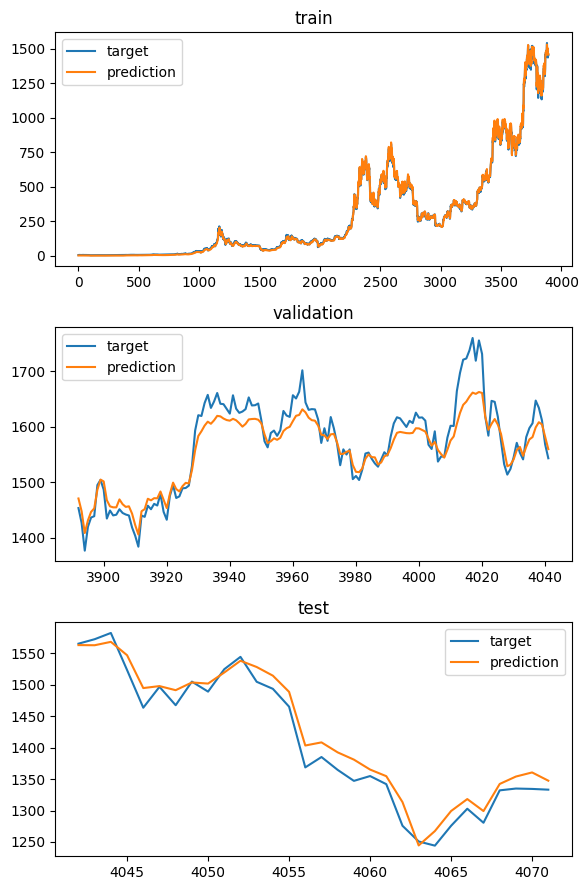

In [41]:
# Regression 테스트 + predict_all (Next_Open 미적용)
class Args:
    epochs = 1
    batch_size = 30
    validation_intervals = 1
    learning_rate = 0.001
    early_stop_patience = 1
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False

args = Args()
ckpt = CHECKPOINT_FILE_PATH / "prob3_reg_no_next_latest.pt"
test_regression(args, use_next_open=False, checkpoint_path=ckpt)
predict_all_regression(args, use_next_open=False, checkpoint_path=ckpt)

[TEST DATA]
 0: 1,562.08 <--> 1,565.45 (Loss:          3.37)
 1: 1,560.90 <--> 1,572.57 (Loss:         11.67)
 2: 1,557.21 <--> 1,582.50 (Loss:         25.28)
 3: 1,543.92 <--> 1,523.51 (Loss:         20.41)
 4: 1,520.17 <--> 1,463.56 (Loss:         56.61)
 5: 1,504.75 <--> 1,496.84 (Loss:          7.92)
 6: 1,500.73 <--> 1,467.53 (Loss:         33.19)
 7: 1,499.68 <--> 1,505.08 (Loss:          5.40)
 8: 1,506.81 <--> 1,489.17 (Loss:         17.64)
 9: 1,516.83 <--> 1,524.84 (Loss:          8.02)
10: 1,525.45 <--> 1,544.47 (Loss:         19.02)
11: 1,525.56 <--> 1,504.83 (Loss:         20.73)
12: 1,516.33 <--> 1,493.60 (Loss:         22.73)
13: 1,485.67 <--> 1,465.23 (Loss:         20.45)
14: 1,432.26 <--> 1,368.62 (Loss:         63.63)
15: 1,402.21 <--> 1,385.10 (Loss:         17.11)
16: 1,381.82 <--> 1,364.62 (Loss:         17.19)
17: 1,373.24 <--> 1,347.15 (Loss:         26.09)
18: 1,364.95 <--> 1,354.83 (Loss:         10.12)
19: 1,345.94 <--> 1,341.92 (Loss:          4.02)
20: 1,30

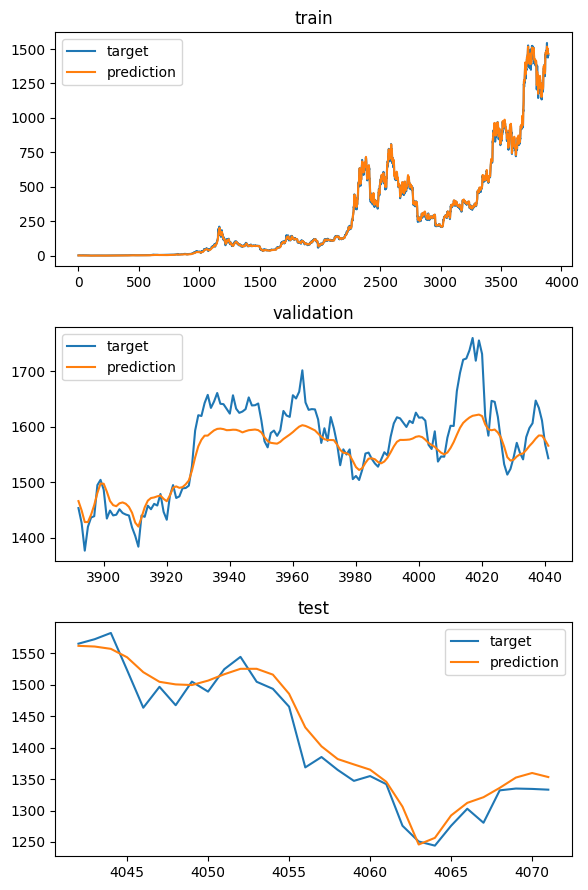

In [42]:
# Regression 테스트 + predict_all (Next_Open 적용)
class Args:
    epochs = 1
    batch_size = 30
    validation_intervals = 1
    learning_rate = 0.001
    early_stop_patience = 1
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False

args = Args()
ckpt = CHECKPOINT_FILE_PATH / "prob3_reg_with_next_latest.pt"
test_regression(args, use_next_open=True, checkpoint_path=ckpt)
predict_all_regression(args, use_next_open=True, checkpoint_path=ckpt)

# Regression 성능 비교 해석 (Next_Open 미적용 vs 적용)
**학습 곡선(Train/Val)**

- 두 실험 모두 Train loss는 초반에 급격히 떨어지고 금방 안정적으로 수렴했다. 따라서 두 비교군 모두 학습은
비교적 잘 되었다.

- 중요한 건 Validation인데, wandb에서 보면 미적용/적용 곡선이 거의 겹친다.
즉 Next_Open을 넣었다고 해서 Validation loss가 눈에 띄게 더 낮아지거나, 더 안정적으로 줄어드는 모습은 뚜렷하지 않았다.

**Test 결과(30개 샘플 출력)**

- Test 출력값을 보면 Next_Open 적용이 “전반적으로 오차가 줄었다”라고 말하기 어렵다.

- 몇몇 샘플에서는 오차가 줄기도 하지만, 반대로 특정 샘플에서는 오차가 크게 늘어난 경우가 있다(예: idx 4, idx 14 같이 차이가 확 커지는 구간).

- 그래서 Next_Open을 넣은 실험은 평균적으로 좋아졌다기보다는, 일부 샘플에서는 오차가 줄었지만 다른 샘플에서는 오차가 커져 전체적으로 일관된 개선이 보이지 않았다.

**원인 분석**

- Next_Open은 다음 날 시가라서 기존 변수(Open/High/Low/Close/Volume)가 이미 가진 흐름이랑 강하게 연관될 가능성이 크다. 그래서 모델 입장에서는 완전히 새로운 정보라기보다는 비슷한 정보가 하나 더 추가된 정보일 가능성이 높다.

- 또 BTC 데이터 자체가 노이즈가 크고, 시가(Open)는 특히 갭이나 급등락이 생기기 쉬워서, Next_Open이 들어가면 어떤 구간에서는 도움이 되지만 어떤 구간에서는 모델 예측을 잘못 끌고 가서 큰 오차를 만드는 상황이 생길 수 있다. 테스트에서 일부 인덱스에서 오차가 확 커진 현상과도 일치한다.

**결론**

- 이번 결과 기준으로는 Next_Open을 추가해도 regression 일반화 성능이 확실히 좋아졌다고 보기는 어렵고, 테스트에서도 일부 샘플에서 오히려 큰 오차가 발생했다.

- 따라서 문제 3에서 regression은 Next_Open 추가가 더 성능이 좋다고 말할 수는 없다.

In [43]:
# Classification 학습 (Next_Open 미적용)
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = True

args = Args()
train_loop_classification(args, run_tag="prob3_cls_no_next", use_next_open=False)

Train loss,█▄▁▁▁▂
Validation loss,▃▅▁▄▄█
epoch,▁▂▄▅▇█
Train loss,0.69165
Validation loss,0.69364
epoch,6


In [44]:
# Classification 학습 (Next_Open 적용)
class Args:
    epochs = 100
    batch_size = 32
    validation_intervals = 5
    learning_rate = 0.001
    early_stop_patience = 5
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = True

args = Args()
train_loop_classification(args, run_tag="prob3_cls_with_next", use_next_open=True)

Train loss,█▁▂▂▁▂
Validation loss,▂▁▁▁▆█
epoch,▁▂▄▅▇█
Train loss,0.69169
Validation loss,0.69321
epoch,6


In [45]:
# Classification 테스트 (Next_Open 미적용)
class Args:
    epochs = 1
    batch_size = 30
    validation_intervals = 1
    learning_rate = 0.001
    early_stop_patience = 1
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False

args = Args()
ckpt = CHECKPOINT_FILE_PATH / "prob3_cls_no_next_latest.pt"
test_classification(args, use_next_open=False, checkpoint_path=ckpt)

[TEST DATA]
TEST RESULTS: 56.667%
 0:   0.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   0.00 <-->   1.00
 3:   0.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   1.00
11:   0.00 <-->   0.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   0.00 <-->   1.00
16:   0.00 <-->   0.00
17:   0.00 <-->   0.00
18:   0.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   0.00
22:   0.00 <-->   0.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   1.00
27:   0.00 <-->   1.00
28:   0.00 <-->   0.00
29:   0.00 <-->   0.00


In [46]:
# Classification 테스트 (Next_Open 적용)
class Args:
    epochs = 1
    batch_size = 30
    validation_intervals = 1
    learning_rate = 0.001
    early_stop_patience = 1
    early_stop_delta = 0.001
    weight_decay = 1e-4
    wandb = False

args = Args()
ckpt = CHECKPOINT_FILE_PATH / "prob3_cls_with_next_latest.pt"
test_classification(args, use_next_open=True, checkpoint_path=ckpt)

[TEST DATA]
TEST RESULTS: 56.667%
 0:   0.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   0.00
 4:   0.00 <-->   0.00
 5:   0.00 <-->   1.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   0.00 <-->   0.00
 9:   0.00 <-->   1.00
10:   0.00 <-->   1.00
11:   0.00 <-->   0.00
12:   0.00 <-->   0.00
13:   0.00 <-->   0.00
14:   0.00 <-->   0.00
15:   0.00 <-->   1.00
16:   0.00 <-->   0.00
17:   0.00 <-->   0.00
18:   0.00 <-->   1.00
19:   0.00 <-->   0.00
20:   0.00 <-->   0.00
21:   0.00 <-->   0.00
22:   0.00 <-->   0.00
23:   0.00 <-->   1.00
24:   0.00 <-->   1.00
25:   0.00 <-->   0.00
26:   0.00 <-->   1.00
27:   0.00 <-->   1.00
28:   0.00 <-->   0.00
29:   1.00 <-->   0.00


# Classification 성능 비교 해석 (Next_Open 미적용 vs 적용)

**학습 곡선(Train/Val)**

- 두 실험 모두 학습은 정상적으로 진행되었고, loss가 감소하는 형태 자체는 유지되었다.
- 다만 Next_Open을 추가했을 때 검증 성능이 눈에 띄게 좋아졌다고 말할 만큼의 변화는 확인되지 않았다. 최종적으로 테스트 성능에서도 차이가 없었기 때문에, 학습 곡선에서 나타나는 작은 차이가 있더라도 일반화 성능 개선으로 이어졌다고 보기 어렵다.

**Test 결과(30개 샘플 출력)**

- 두 실험 모두 TEST RESULTS가 56.667%로 동일했다. 즉 Next_Open을 추가해도 테스트 정확도 자체는 개선되지 않았다.
- 개별 샘플 예측을 보면 두 실험의 예측값 분포가 완전히 같지는 않다. 예를 들어 미적용에서는 0으로 예측하던 일부 인덱스가 적용에서는 1로 바뀐 구간이 존재한다.
- 그럼에도 최종 정확도가 동일하다는 것은, Next_Open 추가로 인해 맞히는 샘플과 틀리는 샘플의 구성이 일부 바뀌었을 뿐, 전체적으로 맞힌 개수는 그대로였다는 뜻이다. 즉 어떤 샘플에서는 개선처럼 보이지만 다른 샘플에서는 그만큼 악화가 함께 발생해 총점이 유지된 형태다.

**원인 분석**

- Next_Open은 다음 날 시가(Open)라서 변동성이 크고 갭이 생기는 날에는 값이 튈 수 있다. 이 특성 때문에 방향성(상승/하락) 분류에서는 일부 구간에선 힌트가 될 수 있지만, 다른 구간에선 오히려 판단을 흐리는 신호로 작동할 수 있다.
- 또한 분류 라벨이 Close의 전일 대비 상승/하락으로 만들어져 있다면, Next_Open은 라벨과 직접적으로 일관된 관계를 보장하지 않는다. 시가가 높게 시작해도 종가가 하락하는 날이 충분히 존재하므로, Next_Open이 항상 정답 방향을 강화해주는 특징이 되기 어렵다.
- 테스트 샘플 수가 30개로 작기 때문에, 몇 개 샘플의 정오답이 바뀌어도 전체 정확도가 쉽게 동일하게 유지될 수 있다. 이 경우 Next_Open의 효과가 있더라도 통계적으로 분명한 차이로 드러나기 어렵다.

**결론**

 않다. 예를 들어 미적용에서는 0으로 예측하던 일부 인덱스가 적용에서는 1로 바뀐 구간이 존재한다.
- 그럼에도 최종 정확도가 동일하다는 것은, Next_Open 추가로 인해 맞히는 샘플과 틀리는 샘플의 구성이 일부 바뀌었을 뿐, 전체적으로 맞힌 개수는 그대로였다는 뜻이다. 즉 어떤 샘플에서는 개선처럼 보이지만 다른 샘플에서는 그만큼 악화가 함께 발생해 총점이 유지된 형태다.

**원인 분석**

- Next_Open은 다음 날 시가(Open)라서 변동성이 크고 갭이 생기는 날에는 값이 튈 수 있다. 이 특성 때문에 방향성(상승/하락) 분류에서는 일부 구간에선 힌트가 될 수 있지만, 다른 구간에선 오히려 판단을 흐리는 신호로 작동할 수 있다.
- 또한 분류 라벨이 Close의 전일 대비 상승/하락으로 만들어져 있다면, Next_Open은 라벨과 직접적으로 일관된 관계를 보장하지 않는다. 시가가 높게 시작해도 종가가 하락하는 날이 충분히 존재하므로, Next_Open이 항상 정답 방향을 강화해주는 특징이 되기 어렵다.
- 테스트 샘플 수가 30개로 작기 때문에, 몇 개 샘플의 정오답이 바뀌어도 전체 정확도가 쉽게 동일하게 유지될 수 있다. 이 경우 Next_Open의 효과가 있더라도 통계적으로 분명한 차이로 드러나기 어렵다.

**결론**

- 이번 결과에서는 Next_Open 추가 여부가 classification 테스트 정확도에 영향을 주지 않았고, 최종 정확도는 동일했다.
- 따라서 문제 3의 classification 비교에서는 Next_Open이 성능을 일관되게 개선한다고 결론내리기 어렵고, 예측이 일부 샘플에서 바뀌더라도 전체적으로는 개선과 악화가 섞여 상쇄된 것으로 해석하는 것이 타당하다.

# 숙제 후기

- 이번 실습을 하면서 제일 크게 느낀 점은 모델 구조 자체보다도 데이터 구성과 실험 세팅을 얼마나 일관되게 유지하느냐가 결과 해석에 더 직접적으로 영향을 준다는 점이었다
- Next_Open을 추가하면 입력 정보가 늘어나니까 성능이 확실히 좋아질 거라고 기대했는데, 실제로는 학습 곡선이 안정적으로 내려가도 테스트에서 개선이 뚜렷하지 않을 수 있다는 걸 확인했다
- 특히 regression은 일부 샘플에서는 더 맞추는 것처럼 보이지만 다른 샘플에서 오차가 커지는 구간이 생겨서, 단순히 평균적인 느낌만으로 성능이 좋아졌다고 말하기 어렵다는 걸 배웠다
- classification도 정확도만 보면 동일하게 나와서, feature 추가가 단순한 향상으로 이어지지 않는다는 점을 다시 체감했다

- 구현 측면에서는 코드 자체보다 실험을 “비교 가능하게” 만드는 과정이 더 까다로웠다
- 같은 task 안에서 프로젝트 이름을 맞추고, run name을 구분하고, checkpoint를 서로 덮어쓰지 않게 관리해야 wandb 그래프가 한눈에 비교되는데, 이 부분이 생각보다 신경 쓸 게 많았다
- 또한 입력 feature 개수가 바뀌면 n_input부터 데이터 shape까지 다 연쇄적으로 바뀌어서, 한 군데만 수정하면 되는 게 아니라 전체 파이프라인이 자연스럽게 맞물리도록 정리해야 했다

- 전체적으로 이번 과제는 모델을 더 복잡하게 만드는 연습이라기보다는, 가설(Next_Open이 도움이 될까)을 세우고 동일 조건으로 실험을 구성한 뒤 결과를 해석하는 연습에 가까웠다고 느꼈다
- 다음에 비슷한 실험을 할 때는 feature를 추가할 때 정말 새로운 정보인지, 라벨과 어떤 관계가 있는지부터 먼저 점검하고 실험을 설계하는 게 더 효율적일 것 같다
